# Deep feature consistent variational auto-encoder

## Introduction

This article introduces the *deep feature consistent variational auto-encoder*<sup>[1]</sup> (DFC VAE) and provides a Keras implementation to demonstrate the advantages over a plain *variational auto-encoder*<sup>[2]</sup> (VAE). The implementation extends [previous work](http://nbviewer.jupyter.org/github/krasserm/bayesian-machine-learning/blob/master/variational_autoencoder.ipynb) on variational auto-encoders.

A plain VAE is trained with a loss function that makes pixel-by-pixel comparisons between the original image and the reconstructured image. This often leads to generated images that are rather blurry. DFC VAEs on the other hand are trained with a loss function that first feeds the original and reconstructed image into a pre-trained convolutional neural network (CNN) to extract higher level features and then compares the these features to compute a so-called *perceptual loss*. 

The core idea of the perceptual loss is to seek consistency between the hidden representations of two images. Images that are perceived to be similar should also have a small perceptual loss even if they significantly differ in a pixel-by-pixel comparison (due to translation, rotation, ...). This results in generated images that look more naturally and are less blurry. The CNN used for feature extraction is called *perceptual model* in this article.

### Plain VAE

In a [previous article](http://nbviewer.jupyter.org/github/krasserm/bayesian-machine-learning/blob/master/variational_autoencoder.ipynb) I introduced the variational auto-encoder (VAE) and how it can be trained with a variational lower bound $\mathcal{L}$ as optimization objective using stochastic gradient ascent methods. In context of stochastic gradient descent its negative value is used as loss function $L_{vae}$ which is defined as the sum of a reconstruction loss $L_{rec}$ and a [Kullback-Leibler (KL) divergence](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence) loss $L_{kl}$:

$$
\begin{align*}
L_{vae} &= L_{rec} + L_{kl} \\
L_{rec} &= - \mathbb{E}_{q(\mathbf{t} \lvert \mathbf{x})} \left[\log p(\mathbf{x} \lvert \mathbf{t})\right] \\
L_{kl} &= \mathrm{KL}(q(\mathbf{t} \lvert \mathbf{x}) \mid\mid p(\mathbf{t}))
\end{align*}
$$

$L_{rec}$ is the expected reconstruction error of an image $\mathbf{x}$, $\mathbf{t}$ is a latent vector and $p(\mathbf{x} \lvert \mathbf{t})$ is the *probabilistic decoder* of the VAE. When trained with gray-scale images like the MNIST dataset, it makes sense to define the probabilistic decoder $p(\mathbf{x} \lvert \mathbf{t})$ as multivariate Bernoulli distribution. The corresponding decoder neural network computes the single parameter $\boldsymbol\phi$ of this distribution from a latent vector. $\boldsymbol\phi$ defines for each generated pixel the probability of being white. The reconstruction loss can be obtained by computing the binary cross-entropy between the original image and the reconstructed image which is a pixel-by-pixel measurement (Fig. 1).

$L_{kl}$ is the KL divergence between the variational distribution $q(\mathbf{t} \lvert \mathbf{x})$ and a prior $p(\mathbf{t})$. $q(\mathbf{t} \lvert \mathbf{x})$ is the *probabilistic encoder* of the VAE. The probabilistic encoder $q(\mathbf{t} \lvert \mathbf{x})$ is a multivariate Gaussian distribution whose mean and variance is computed by the corresponding encoder neural network from an input image. The prior $p(\mathbf{t})$ is chosen to be a mutlivariate standard normal distribution. $L_{kl}$ acts as a regularization term ensuring that $q(\mathbf{t} \lvert \mathbf{x})$ doesn't diverge too much from prior $p(\mathbf{t})$.

![vae](images/vae-dfc/vae-4.png)

*Fig. 1: Plain variational auto-encoder*

### DFC VAE

A plain VAE can be converted to a DFC VAE during training by replacing the pixel-by-pixel reconstruction loss $L_{rec}$ with a feature perceptual loss $L_{p}$. At each layer of the perceptual model, the hidden representations of the original and the reconstructed image are taken and their squared Euclidean distance is calculated. This gives a perceptual loss component $L_{p}^i$ at each layer $i$. The overall perceptual loss $L_{p}$ is a weighted sum of the losses computed at each layer (Fig. 2)

$$
\begin{align*}
L_{p} &= \sum_{i} w_i L_{p}^i \\
L_{p}^i &= \left\lVert \Phi(\mathbf{x})^i - \Phi(\mathbf{\bar x})^i \right\rVert ^2
\end{align*}
$$

where $pm(\mathbf{x})^i$ and $pm(\mathbf{\bar x})^i$ are the representations of the original image $\mathbf{x}$ and the reconstructed image $\mathbf{\bar x}$ at layer $i$ of the perceptual model $\Phi$. Weights $w_i$ are hyperparameters in the following implementation. For DFC VAE training the sum of the perceptual loss the KL divergence loss is used:

$$
L_{vae_{dfc}} = L_{p} + L_{kl}
$$


![vae](images/vae-dfc/vae-dfc-4.png)

*Fig. 2. Deep feature consistent variational auto-encoder*

## Training

In contrast to the original paper we will use the MNIST handwritten digits dataset for training and for demonstrating how a perceptual loss improves over a pixel-by-pixel reconstruction loss. We can therefore reuse the VAE [encoder](https://github.com/krasserm/bayesian-machine-learning/blob/6962f02168fd82cd01ed6dfe3937e98b10a58b02/variational_autoencoder_opt_util.py#L15-L36) and [decoder](https://github.com/krasserm/bayesian-machine-learning/blob/master/variational_autoencoder_opt_util.py#L38-L53) architectures from the already mentioned [previous article](http://nbviewer.jupyter.org/github/krasserm/bayesian-machine-learning/blob/master/variational_autoencoder.ipynb). The perceptual model is a [small CNN](https://github.com/krasserm/bayesian-machine-learning/blob/6962f02168fd82cd01ed6dfe3937e98b10a58b02/variational_autoencoder_opt_util.py#L91-L105) (Fig. 3) that has already been trained in [another context](http://nbviewer.jupyter.org/github/krasserm/bayesian-machine-learning/blob/master/variational_autoencoder_opt.ipynb#Optimization-objectives) to classify MNIST images.

![pm](images/vae-dfc/classifier-3.png)

*Fig. 3: Perceptual model used for DFC VAE training*

Depending on the value of the `use_pretrained` variable either pre-trained weights for the plain VAE and DFC VAE are loaded (default) or they are trained from scratch. The dimensionality of the latent space is 5 by default.

In [1]:
# True if pre-trained weights for the VAEs shall be
# loaded, False for training the VAEs from scratch.
use_pretrained = True

# Dimensionality of latent space. Do not change to 
# a value other than 5 if use_pretrained = True,
# otherwise create_vae (below) will raise an error.
latent_dim = 5

The perceptual model is never trained here but always loaded as pre-trained model. For computing the perceptual loss the representations of the first and third hidden layer (`conv2d_6` and `conv2d_7`) are used and weighted with `1.0` each:

In [2]:
from keras.models import load_model

# Load pre-trained preceptual model. A simple CNN for
# classifying MNIST handwritten digits.
pm = load_model('models/vae-opt/classifier.h5')

# Names and weights of perceptual model layers 
# selected for calculating the perceptual loss.
selected_pm_layers = ['conv2d_6', 'conv2d_7']
selected_pm_layer_weights = [1.0, 1.0]

Using TensorFlow backend.


Since we will use the same encoder and decoder architecture for the plain VAE and the DFC VAE we can define a generic `create_vae` function for creating both models. During training they also use the same KL divergence loss operation which is also returned by `create_vae`.

In [3]:
import variational_autoencoder_opt_util as vae_util

from keras import backend as K
from keras import layers
from keras.models import Model

def create_vae(latent_dim, return_kl_loss_op=False):
    '''
    Creates a VAE able to auto-encode MNIST images.

    Args:
        latent_dim: dimensionality of latent space
        return_kl_loss_op: whether to return the operation for 
                           computing the KL divergence loss.
                           
    Returns:
        The VAE model. If return_kl_loss_op is True, then the
        operation for computing the KL divergence loss is 
        additionally returned.
    '''

    if use_pretrained:
        assert latent_dim == 5, 'latent_dim must be 5 if pre-trained VAEs are used'
    
    encoder = vae_util.create_encoder(latent_dim)
    decoder = vae_util.create_decoder(latent_dim)
    sampler = vae_util.create_sampler()

    x = layers.Input(shape=(28, 28, 1), name='image')
    t_mean, t_log_var = encoder(x)
    t = sampler([t_mean, t_log_var])
    t_decoded = decoder(t)

    model = Model(x, t_decoded, name='vae')
    
    if return_kl_loss_op:
        kl_loss = -0.5 * K.sum(1 + t_log_var \
                                 - K.square(t_mean) \
                                 - K.exp(t_log_var), axis=-1)
        return model, kl_loss
    else:
        return model

    
# Create plain VAE model and associated KL divergence loss operation
vae, vae_kl_loss = create_vae(latent_dim, return_kl_loss_op=True)

# Create DFC VAE model and associated KL divergence loss operation
vae_dfc, vae_dfc_kl_loss = create_vae(latent_dim, return_kl_loss_op=True)

The only difference between the plain VAE and the DFC VAE is that the plain VAE uses `reconstruction_loss` during training and the DFC VAE uses `perceptual_loss`. These losses are combined with the KL divergence loss in the `vae_loss` and `vae_dfc_loss` functions respectively:

In [4]:
def vae_loss(x, t_decoded):
    '''Total loss for the plain VAE'''
    return K.mean(reconstruction_loss(x, t_decoded) + vae_kl_loss)


def vae_dfc_loss(x, t_decoded):
    '''Total loss for the DFC VAE'''
    return K.mean(perceptual_loss(x, t_decoded) + vae_dfc_kl_loss)


def reconstruction_loss(x, t_decoded):
    '''Reconstruction loss for the plain VAE'''
    return K.sum(K.binary_crossentropy(
        K.batch_flatten(x), 
        K.batch_flatten(t_decoded)), axis=-1)


def perceptual_loss(x, t_decoded):
    '''Perceptual loss for the DFC VAE'''
    outputs = [pm.get_layer(l).output for l in selected_pm_layers]
    model = Model(pm.input, outputs)

    h1_list = model(x)
    h2_list = model(t_decoded)
    
    rc_loss = 0.0
    
    for h1, h2, weight in zip(h1_list, h2_list, selected_pm_layer_weights):
        h1 = K.batch_flatten(h1)
        h2 = K.batch_flatten(h2)
        rc_loss = rc_loss + weight * K.sum(K.square(h1 - h2), axis=-1)
    
    return rc_loss

After loading the MNIST dataset and normalizing pixel values to interval $[0,1]$ we have now everything we need to train the two auto-encoders. This takes a few minutes per model on a GPU. The default setting however is to load the pre-trained weights for the auto-encoders instead of training them.

In [5]:
from variational_autoencoder_dfc_util import load_mnist_data

(x_train, _), (x_test, y_test) = load_mnist_data(normalize=True)

In [6]:
if use_pretrained:
    vae.load_weights('models/vae-dfc/vae_weights.h5')
else:
    vae.compile(optimizer='rmsprop', loss=vae_loss)
    vae.fit(x=x_train, y=x_train, epochs=15, shuffle=True, validation_data=(x_test, x_test), verbose=2)

In [7]:
if use_pretrained:
    vae_dfc.load_weights('models/vae-dfc/vae_dfc_weights.h5')    
else:
    vae_dfc.compile(optimizer='rmsprop', loss=vae_dfc_loss)
    vae_dfc.fit(x=x_train, y=x_train, epochs=15, shuffle=True, validation_data=(x_test, x_test), verbose=2)

## Experiments

### Analyze blur of generated images

The introduction stated that images generated by a DFC VAE tend to be less blurry than images generated by a plain VAE with the same architecture. The following example shows 10 manually selected images from the MNIST test set and their reconstructions by the plain VAE and the DFC VAE. If you run this notebook with `use_pretrained = False` then 10 randomly selected images from the MNIST test set are used instead. The remainder of this article assumes that `use_pretrained = True`.

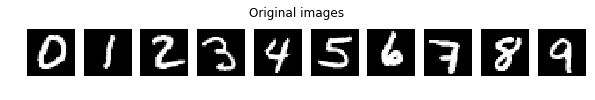

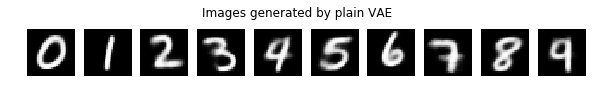

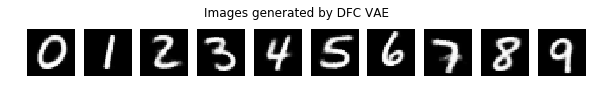

In [8]:
from variational_autoencoder_dfc_util import plot_image_rows

def encode(model, images):
    '''Encodes images with the encoder of the given auto-encoder model'''
    return model.get_layer('encoder').predict(images)[0]


def decode(model, codes):
    '''Decodes latent vectors with the decoder of the given auto-encoder model'''
    return model.get_layer('decoder').predict(codes)


def encode_decode(model, images):
    '''Encodes and decodes an image with the given auto-encoder model'''
    return decode(model, encode(model, images))


if use_pretrained:
    # Manually selected indices corresponding to digits 0-9 in the test set
    selected_idx = [5531, 2553, 1432, 4526, 9960, 6860, 6987, 3720, 5003, 9472]
else:
    # Randomly selected indices 
    selected_idx = np.random.choice(range(x_test.shape[0]), 10, replace=False)

selected = x_test[selected_idx]
selected_dec_vae = encode_decode(vae, selected)
selected_dec_vae_dfc = encode_decode(vae_dfc, selected)

plot_image_rows([selected, selected_dec_vae, selected_dec_vae_dfc], 
                ['Original images', 
                 'Images generated by plain VAE', 
                 'Images generated by DFC VAE'])

One can clearly see that the images generated by the DFC VAE are less blurry than the images generated by the plain VAE. A similar trend can also be seen for other samples. To quantify blur we compute the Laplacian variance for each image to have a single measure of focus<sup>[3]</sup> (see also [Blur detection with OpenCV](https://www.pyimagesearch.com/2015/09/07/blur-detection-with-opencv/)). 

In [9]:
import cv2

def laplacian_variance(images):
    return [cv2.Laplacian(image, cv2.CV_32F).var() for image in images]

The Laplacian variance increases with increased focus of an image or decreases with increased blur. Furthermore, images with a smaller amount of edges tend to have a smaller Laplacian variance (the [Laplacian kernel](https://en.wikipedia.org/wiki/Discrete_Laplace_operator#Image_Processing) is often used for edge detection in images). Therefore we first have to analyze the Laplacian variances for digit classes 0-9 in the MNIST test set before we can compare blur differences in generated images:

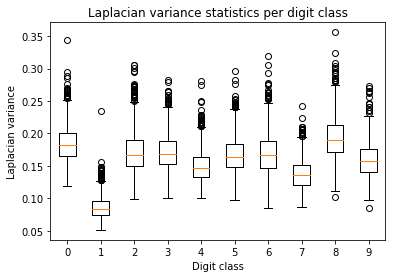

In [10]:
import matplotlib.pyplot as plt

%matplotlib inline

laplacian_variances = [laplacian_variance(x_test[y_test == i]) for i in range(10)]

plt.boxplot(laplacian_variances, labels=range(10));
plt.xlabel('Digit class')
plt.ylabel('Laplacian variance')
plt.title('Laplacian variance statistics per digit class');

In a first approximation we can say that the Laplacian variance statistics for all digit classes are comparable except for class 1. It is no surprise that the average Laplacian variance of images showing a 1 is lower compared to other images as the amount of detectable edges is lower there as well. This also explain the (less prominent) difference between digit classes 7 and 8. 

The following histogram shows the frequency of Laplacian variances for all images in the MNIST test set except for digit class 1. The frequencies for the original images as well as for the images reconstructed by the plain VAE and the DFC VAE are shown in different colors.

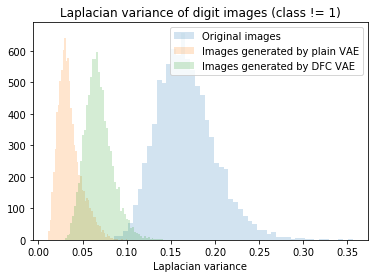

In [11]:
from variational_autoencoder_dfc_util import plot_laplacian_variances

x_dec_vae = encode_decode(vae, x_test)
x_dec_vae_dfc = encode_decode(vae_dfc, x_test)

not_ones = y_test != 1

lvs_1 = laplacian_variance(x_test[not_ones])
lvs_2 = laplacian_variance(x_dec_vae[not_ones])
lvs_3 = laplacian_variance(x_dec_vae_dfc[not_ones])

plot_laplacian_variances(lvs_1, lvs_2, lvs_3, title='Laplacian variance of digit images (class != 1)')

On average, the original images have the highest Laplacian variance (highest focus or least blur) whereas the reconstructed images are more blurry. But the images reconstructed by the DFC VAE are significantly less blurry than those reconstructed by the plain VAE. The statistical significance of this difference can verified with a [t-test](https://en.wikipedia.org/wiki/Student%27s_t-test) for paired samples (the same test images are used by both auto-encoders):

In [12]:
from scipy.stats import ttest_rel

res = ttest_rel(lvs_1, lvs_2)
print(f'T-score = {res.statistic:.2f}, p-value = {res.pvalue:.2f}')

T-score = 364.80, p-value = 0.00


The [T-score](https://en.wikipedia.org/wiki/T-statistic) is very large and the [p-value](https://en.wikipedia.org/wiki/P-value) is essentially zero i.e. definitely lower than 0.05. We can therefore conclude that images generated by the DFC VAE are significantly less blurry than those generated by the plain VAE. For images of class 1, the difference is less clear when looking at the histogram but still significant as the p-value is essentially zero here as well:

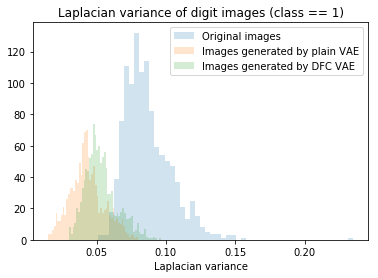

In [13]:
ones = y_test == 1

lvs_1 = laplacian_variance(x_test[ones])
lvs_2 = laplacian_variance(x_dec_vae[ones])
lvs_3 = laplacian_variance(x_dec_vae_dfc[ones])

plot_laplacian_variances(lvs_1, lvs_2, lvs_3, title='Laplacian variance of digit images (class == 1)')

In [14]:
res = ttest_rel(lvs_1, lvs_2)
print(f'T-score = {res.statistic:.2f}, p-value = {res.pvalue:.2f}')

T-score = 78.94, p-value = 0.00


Although the distributions for class 1 are more skewed, usage of the t-test can still be justified as the sample size is large enough (1135 class 1 images in the MNIST test set).

### Linear interpolation between images

Linear interpolation between two images is done in latent space. A finite number of points are sampled at equal distances on a straight line between the latent representations of the input images and then decoded back into pixel space:

In [15]:
import numpy as np

def linear_interpolation(model, x_from, x_to, steps):
    n = steps + 1

    t_from = encode(model, np.array([x_from]))[0]
    t_to = encode(model, np.array([x_to]))[0]

    diff = t_to - t_from
    inter = np.zeros((n, t_from.shape[0]))
    for i in range(n):
        inter[i] = t_from + i / steps * diff

    return decode(model, inter)

Let's use the `linear_interpolation` function to interpolate between digits 1 and 5 and compare results generated by the plain VAE and the DFC VAE:

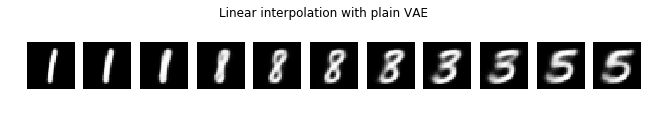

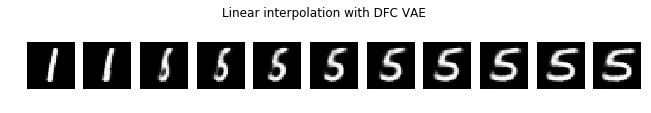

In [16]:
def plot_linear_interpolations(x_from, x_to, steps=10):
    plot_image_rows([linear_interpolation(vae, x_from, x_to, steps), 
                     linear_interpolation(vae_dfc, x_from, x_to, steps)], 
                    ['Linear interpolation with plain VAE', 
                     'Linear interpolation with DFC VAE'])

plot_linear_interpolations(selected[1], selected[5])

In addition to generating less blurry images, the interpolation done by the DFC VAE is also less surprising as it doesn't generate intermediate digits of values other than 1 and 5. It just distorts the vertical bar representing a 1 more and more to finally become a 5. On the other hand, the plain VAE generates the intermediate digits 8 and 3. The situation is similar for an interpolation between digits 1 and 3:

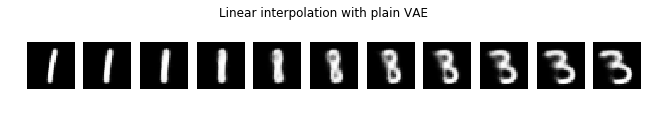

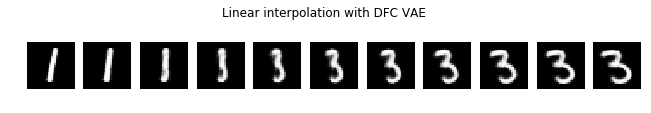

In [17]:
plot_linear_interpolations(selected[1], selected[3])

This doesn't mean that the interpolation with the DFC VAE never creates intermediate digits of other value. For example, an interpolation between digits 3 and 7 creates an intermediate 8 but the overall quality of the interpolation is still much better (less blurry) compared to the plain VAE.

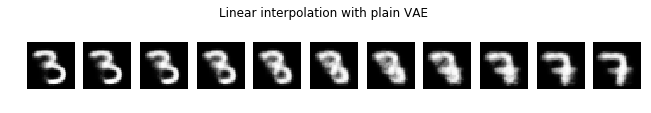

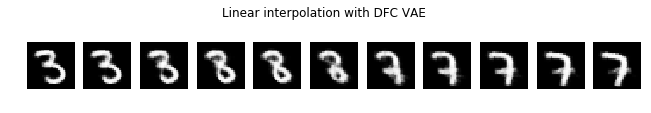

In [18]:
plot_linear_interpolations(selected[3], selected[7])

## Other implementations

The original paper<sup>[1]</sup> uses a different DFC VAE architecture and a training dataset with 202,599 face images ([CelebA](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html)). Their perceptual model is a 19-layer VGGNet<sup>[4]</sup> trained on ImageNet. A [Torch](http://torch.ch/) implementation together with a pre-trained model is available [here](https://github.com/houxianxu/DFC-VAE). A corresponding Tensorflow implementation is available at [davidsandberg/facenet](https://github.com/davidsandberg/facenet/wiki/Variational-autoencoder). In contrast to the original paper, the latter implementation uses a pre-trained FaceNet<sup>[5]</sup> model as perceptual model.

## References

- \[1\] Xianxu Hou, Linlin Shen, Ke Sun, Guoping Qiu [Deep Feature Consistent Variational Autoencoder](https://arxiv.org/abs/1610.00291).
- \[2\] Diederik P Kingma, Max Welling [Auto-Encoding Variational Bayes](https://arxiv.org/abs/1312.6114).  
- \[3\] Said Pertuz, Domenec Puig, Miguel Angel Garcia [Analysis of focus measure operators for shape-from-focus](https://dl.acm.org/citation.cfm?id=2431007).
- \[4\] Karen Simonyan, Andrew Zisserman [Very Deep Convolutional Networks for Large-Scale Image Recognition](https://arxiv.org/abs/1409.1556).
- \[5\] Florian Schroff, Dmitry Kalenichenko, James Philbin [FaceNet: A Unified Embedding for Face Recognition and Clustering](https://arxiv.org/abs/1503.03832).

